In [7]:
# load package
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation  import train_test_split
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.model_selection import learning_curve
# set path
import os
default_path = "/Users/francislin/Desktop/Machine_Learning_Workshop/Titanic/"
os.chdir(default_path)

# skip interaction warning
import warnings; 
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
# Data Prepararion
# read data
train=pd.read_csv('train.csv',encoding='big5')
test=pd.read_csv('test.csv',encoding='big5')
submit=pd.read_csv('gender_submission.csv',encoding='big5')

In [9]:
# append in ONE data
data=train.append(test, ignore_index=True)

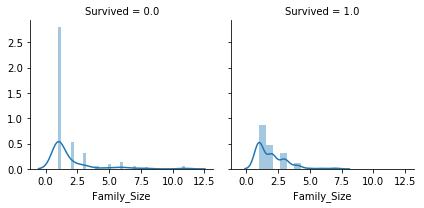

In [10]:
data['Family_Size']=data['Parch']+data['SibSp']+1
g=sns.FacetGrid(data,col='Survived')
g.map(sns.distplot,'Family_Size',kde=True)#kde是否要折線圖的參數

In [11]:
#設法整理出「尊稱」這個因子
data['Title1']=data['Name'].str.split('.',expand=True)[0]
#expand=True是讓資料在dataframe展開欄位
#1是選第二項的title
# 切出尊稱
data['Title1']=data['Title1'].str.split(', ',expand=True)[1].str.strip()#[1]代表切出第2個'dlm'前面到第一個的字串
# 秀出dintinct後的title1
data['Title1'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [12]:
#合併成比較常出現的姓氏在Title2
data['Title2']=''
for idx, row in data.iterrows():  # 請務必記得加上idx，不然跑回圈的item會變成(idx, row)
    Sex = row['Sex']
    Title1=row['Title1']
    if Title1=='Master':
        Title2='Master'
    elif Title1=='Mrs':
        Title2='Mrs'
    elif Title1=='Miss':
        Title2='Miss'
    elif Sex=='male':
        Title2='Mr'
    else:
        Title2='Miss'
    data.loc[idx,'Title2']=Title2 #???
data['Title2'].unique()
tt2 = data.groupby(by='Title2', as_index=False).agg({'PassengerId': pd.Series.nunique})
tt2

,Title2,PassengerId
0,Master,61
1,Miss,269
2,Mr,782
3,Mrs,197


In [13]:
# 票的前幾碼代號可能有意義，流水編沒有所以拿掉
data['Ticket_info'] = data['Ticket'].apply(lambda x : x.upper().replace(".","").strip().split(' ')[0] if not x.isdigit() else 'X')
data['Ticket_info'].unique()

array(['A/5', 'PC', 'STON/O2', 'X', 'PP', 'CA', 'SC/PARIS', 'SC/A4',
       'A/4', 'SP', 'SOC', 'SO/C', 'W/C', 'SOTON/OQ', 'WEP', 'STON/O',
       'A4', 'C', 'SOP', 'A5', 'FA', 'LINE', 'FCC', 'SW/PP', 'SCO/W',
       'P/PP', 'SC', 'SC/AH', 'A/S', 'WE/P', 'SO/PP', 'FC', 'SOTON/O2',
       'CA/SOTON', 'SC/A3', 'STON/OQ', 'AQ/4', 'A', 'LP', 'AQ/3'],
      dtype=object)

In [14]:
tt = data.groupby(by='Ticket_info', as_index=False).agg({'PassengerId': pd.Series.nunique})
tt.head()

,Ticket_info,PassengerId
0,A,1
1,A/4,9
2,A/5,25
3,A/S,1
4,A4,1


In [15]:
tt['PassengerId'].describe()

count     40.000000
mean      32.725000
std      150.943866
min        1.000000
25%        1.000000
50%        2.500000
75%        8.250000
max      957.000000
Name: PassengerId, dtype: float64

In [16]:
#把count distinct的ticket_info低於第一四分位數的都改成None
tt['Ticket_info_rev']=tt['Ticket_info']
tt.Ticket_info_rev[tt.PassengerId<14]='None' #STONO是14
tt

,Ticket_info,PassengerId,Ticket_info_rev
0,A,1,None
1,A/4,9,None
2,A/5,25,A/5
3,A/S,1,None
4,A4,1,None
5,A5,3,None
6,AQ/3,1,None
7,AQ/4,1,None
8,C,8,None
9,CA,68,CA


In [17]:
#leftjoin Ticket_info_rev到大表
tt=tt.drop(['PassengerId'], axis=1)
data=pd.merge(left=data, right=tt,how='left', on=['Ticket_info', 'Ticket_info'])
data.head(4)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Title1,Title2,Ticket_info,Ticket_info_rev
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2,Mr,Mr,A/5,A/5
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,Mrs,Mrs,PC,PC
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,Miss,Miss,STON/O2,None
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,Mrs,Mrs,X,X


In [18]:
# 抓船艙第一碼英文
# 送出kaggle成績沒有比較好，一堆空的也是合理
data['Cabin_info']=data['Cabin'].str[:1]
data['Cabin_info']=data['Cabin_info'].fillna('N')#空的補N
data['Cabin_info'].unique()

array(['N', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [19]:
'''
data['Cabin_info2']=data['Cabin_info']
data.Cabin_info2[data.Cabin_info in ('N','C')]='mm'
data.head()'''

"\ndata['Cabin_info2']=data['Cabin_info']\ndata.Cabin_info2[data.Cabin_info in ('N','C')]='mm'\ndata.head()"

In [20]:
#整併人數太少的cabin
#把'F','G','T'變成'Merged'
data['Cabin_info'].replace(['F','G','T'],'Merged',inplace=True)#inplace如果是false就是改爽的不會更動到值

In [21]:
#
print('Embarked原遺漏的人數：',data['Embarked'].isnull().sum())
#最多在S港上傳，填補遺漏值
data['Embarked']=data['Embarked'].fillna('S')

Embarked原遺漏的人數： 2


In [22]:
#
print('Fare原遺漏的人數：',data['Fare'].isnull().sum())
#用平均填補遺漏值
data['Fare']=data['Fare'].fillna(data['Fare'].mean())

Fare原遺漏的人數： 1


In [23]:
#
print('Age原遺漏的人數：',data['Age'].isnull().sum())
#用中位數填補遺漏值
data['Age']=data['Age'].fillna(data['Age'].median())

Age原遺漏的人數： 263


In [24]:
#用(找是否有別名
data['NickName_ind']= data['Name'].str.contains('\(',na=False)*1
data['Quotation_ind']= data['Name'].str.contains('\"',na=False)*1
qta = data.groupby(by='Quotation_ind', as_index=False).agg({'PassengerId': pd.Series.nunique})
qta.head()

,Quotation_ind,PassengerId
0,0,1234
1,1,75


In [25]:
data.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Family_Size', 'Title1',
       'Title2', 'Ticket_info', 'Ticket_info_rev', 'Cabin_info',
       'NickName_ind', 'Quotation_ind'],
      dtype='object')

In [26]:
deplicate_ticket = []
for tk in data.Ticket.unique():
    tem = data.loc[data.Ticket == tk, 'Fare']
    #print(tem.count())
    if tem.count() > 1:
        #print(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare']])
        deplicate_ticket.append(data.loc[data.Ticket == tk,['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Family_Size', 'Title1',
       'Title2', 'Ticket_info', 'Ticket_info_rev', 'Cabin_info',
       'NickName_ind', 'Quotation_ind']])
deplicate_ticket = pd.concat(deplicate_ticket)
deplicate_ticket.head(14)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Title1,Title2,Ticket_info,Ticket_info_rev,Cabin_info,NickName_ind,Quotation_ind
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,Mrs,Mrs,PC,PC,C,1,0
1125,39.0,C85,C,71.2833,"Cumings, Mr. John Bradley",0,1126,1,male,1,NaN,PC 17599,2,Mr,Mr,PC,PC,C,0,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,Mrs,Mrs,X,X,C,1,0
137,37.0,C123,S,53.1000,"Futrelle, Mr. Jacques Heath",0,138,1,male,1,0.0,113803,2,Mr,Mr,X,X,C,0,0
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,1,Mr,Mr,X,X,E,0,0
1037,28.0,E46,S,51.8625,"Hilliard, Mr. Herbert Henry",0,1038,1,male,0,NaN,17463,1,Mr,Mr,X,X,E,0,0
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,5,Master,Master,X,X,N,0,0
24,8.0,NaN,S,21.0750,"Palsson, Miss. Torborg Danira",1,25,3,female,3,0.0,349909,5,Miss,Miss,X,X,N,0,0
374,3.0,NaN,S,21.0750,"Palsson, Miss. Stina Viola",1,375,3,female,3,0.0,349909,5,Miss,Miss,X,X,N,0,0
567,29.0,NaN,S,21.0750,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",4,568,3,female,0,0.0,349909,5,Mrs,Mrs,X,X,N,1,0


In [27]:
df_fri = deplicate_ticket.loc[(deplicate_ticket.Family_Size == 1) & (deplicate_ticket.Survived.notnull())].head(7)
df_fami = deplicate_ticket.loc[(deplicate_ticket.Family_Size > 1) & (deplicate_ticket.Survived.notnull())].head(7)
display(df_fri,df_fami)
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print('friends: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_Size == 1]))
print('families: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_Size > 1]))

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Title1,Title2,Ticket_info,Ticket_info_rev,Cabin_info,NickName_ind,Quotation_ind
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,1,Mr,Mr,X,X,E,0,0
20,35.0,NaN,S,26.0000,"Fynney, Mr. Joseph J",0,21,2,male,0,0.0,239865,1,Mr,Mr,X,X,N,0,0
791,16.0,NaN,S,26.0000,"Gaskell, Mr. Alfred",0,792,2,male,0,0.0,239865,1,Mr,Mr,X,X,N,0,0
195,58.0,B80,C,146.5208,"Lurette, Miss. Elise",0,196,1,female,0,1.0,PC 17569,1,Miss,Miss,PC,PC,B,0,0
681,27.0,D49,C,76.7292,"Hassab, Mr. Hammad",0,682,1,male,0,1.0,PC 17572,1,Mr,Mr,PC,PC,D,0,0
61,38.0,B28,S,80.0000,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,1,Miss,Miss,X,X,B,0,0
829,62.0,B28,S,80.0000,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,1,Mrs,Mrs,X,X,B,1,0


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Title1,Title2,Ticket_info,Ticket_info_rev,Cabin_info,NickName_ind,Quotation_ind
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,Mrs,Mrs,PC,PC,C,1,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,Mrs,Mrs,X,X,C,1,0
137,37.0,C123,S,53.1000,"Futrelle, Mr. Jacques Heath",0,138,1,male,1,0.0,113803,2,Mr,Mr,X,X,C,0,0
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,5,Master,Master,X,X,N,0,0
24,8.0,NaN,S,21.0750,"Palsson, Miss. Torborg Danira",1,25,3,female,3,0.0,349909,5,Miss,Miss,X,X,N,0,0
374,3.0,NaN,S,21.0750,"Palsson, Miss. Stina Viola",1,375,3,female,3,0.0,349909,5,Miss,Miss,X,X,N,0,0
567,29.0,NaN,S,21.0750,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",4,568,3,female,0,0.0,349909,5,Mrs,Mrs,X,X,N,1,0


people keep the same ticket: 596 
friends: 127 
families: 469 


In [28]:
# the same ticket family or friends
data['Connected_Survival'] = 0.5 # default 
for _, df_grp in data.groupby('Ticket'):
    if (len(df_grp) > 1):
        for ind, row in df_grp.iterrows():
            smax = df_grp.drop(ind)['Survived'].max()
            smin = df_grp.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data.loc[data['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smin==0.0):
                data.loc[data['PassengerId'] == passID, 'Connected_Survival'] = 0
#print
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print("people have connected information : %.0f" 
      %(data[data['Connected_Survival']!=0.5].shape[0]))
data.groupby('Connected_Survival')[['Survived']].mean().round(3)

people keep the same ticket: 596 
people have connected information : 496


,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


In [29]:
#留下準備get_dummies的欄位
for_dummy_data=data.drop(['Name','Cabin','Ticket','Ticket_info','Title1'], axis=1)
for_dummy_data.head(3)

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Family_Size,Title2,Ticket_info_rev,Cabin_info,NickName_ind,Quotation_ind,Connected_Survival
0,22.0,S,7.2500,0,1,3,male,1,0.0,2,Mr,A/5,N,0,0,0.5
1,38.0,C,71.2833,0,2,1,female,1,1.0,2,Mrs,PC,C,1,0,0.5
2,26.0,S,7.9250,0,3,3,female,0,1.0,1,Miss,None,N,0,0,0.5


In [47]:
data_dummies = pd.get_dummies(for_dummy_data)
#columns可以指定哪些欄位要get_dummies
data_dummies.head(3)
#data= pd.merge(left=data, right=data_dummies, how='left', left_on='PassengerId', right_on='PassengerId',)
#data.head(4)

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,Family_Size,NickName_ind,Quotation_ind,...,Ticket_info_rev_STON/O,Ticket_info_rev_W/C,Ticket_info_rev_X,Cabin_info_A,Cabin_info_B,Cabin_info_C,Cabin_info_D,Cabin_info_E,Cabin_info_Merged,Cabin_info_N
0,22.0,7.2500,0,1,3,1,0.0,2,0,0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,71.2833,0,2,1,1,1.0,2,1,0,...,0,0,0,0,0,1,0,0,0,0
2,26.0,7.9250,0,3,3,0,1.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [48]:
data_dummies.columns

Index(['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'SibSp', 'Survived',
       'Family_Size', 'NickName_ind', 'Quotation_ind', 'Connected_Survival',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male',
       'Title2_Master', 'Title2_Miss', 'Title2_Mr', 'Title2_Mrs',
       'Ticket_info_rev_A/5', 'Ticket_info_rev_CA', 'Ticket_info_rev_None',
       'Ticket_info_rev_PC', 'Ticket_info_rev_SC/PARIS',
       'Ticket_info_rev_SOTON/OQ', 'Ticket_info_rev_STON/O',
       'Ticket_info_rev_W/C', 'Ticket_info_rev_X', 'Cabin_info_A',
       'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_E',
       'Cabin_info_Merged', 'Cabin_info_N'],
      dtype='object')

In [49]:
#感覺是把文字類別轉成某種數字
#get_dummies了所以不必這一cell
'''
data['Sex'] = data['Sex'].astype('category').cat.codes
data['Embarked'] = data['Embarked'].astype('category').cat.codes
data['Pclass'] = data['Pclass'].astype('category').cat.codes
data['Title2'] = data['Title2'].astype('category').cat.codes
data['Ticket_info'] = data['Ticket_info'].astype('category').cat.codes
data['Cabin_info'] = data['Cabin_info'].astype('category').cat.codes
data.head(4)
'''

"\ndata['Sex'] = data['Sex'].astype('category').cat.codes\ndata['Embarked'] = data['Embarked'].astype('category').cat.codes\ndata['Pclass'] = data['Pclass'].astype('category').cat.codes\ndata['Title2'] = data['Title2'].astype('category').cat.codes\ndata['Ticket_info'] = data['Ticket_info'].astype('category').cat.codes\ndata['Cabin_info'] = data['Cabin_info'].astype('category').cat.codes\ndata.head(4)\n"

In [50]:
# 運用'Survived'欄位來判斷訓練集還是測試集
dataTrain = data_dummies[pd.notnull(data_dummies['Survived'])].sort_values(by=["PassengerId"])
dataTest = data_dummies[~pd.notnull(data_dummies['Survived'])].sort_values(by=["PassengerId"])
dataTrain.columns

Index(['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'SibSp', 'Survived',
       'Family_Size', 'NickName_ind', 'Quotation_ind', 'Connected_Survival',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male',
       'Title2_Master', 'Title2_Miss', 'Title2_Mr', 'Title2_Mrs',
       'Ticket_info_rev_A/5', 'Ticket_info_rev_CA', 'Ticket_info_rev_None',
       'Ticket_info_rev_PC', 'Ticket_info_rev_SC/PARIS',
       'Ticket_info_rev_SOTON/OQ', 'Ticket_info_rev_STON/O',
       'Ticket_info_rev_W/C', 'Ticket_info_rev_X', 'Cabin_info_A',
       'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_E',
       'Cabin_info_Merged', 'Cabin_info_N'],
      dtype='object')

In [58]:
dataTrain = dataTrain[['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Survived',
       'Family_Size', 'NickName_ind', 'Quotation_ind', 'Connected_Survival',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male',
       'Title2_Master', 'Title2_Miss', 'Title2_Mr', 'Title2_Mrs',
       #'Ticket_info_rev_A/5', 'Ticket_info_rev_CA', 
       #'Ticket_info_rev_PC', 'Ticket_info_rev_SC/PARIS',
       #'Ticket_info_rev_SOTON/OQ', 'Ticket_info_rev_W/C',
       'Ticket_info_rev_X', 'Ticket_info_rev_STON/O','Ticket_info_rev_None',
       #'Cabin_info_A', 'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_E', 'Cabin_info_Merged'
       'Cabin_info_E', 'Cabin_info_N']]
#把上面dataTrain.columns的結果貼到dataTest，再去掉'Survived'
dataTest = dataTest[['Age', 'Fare', 'Parch', 'Pclass', 'SibSp',
       'Family_Size', 'NickName_ind', 'Quotation_ind', 'Connected_Survival',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male',
       'Title2_Master', 'Title2_Miss', 'Title2_Mr', 'Title2_Mrs',
       #'Ticket_info_rev_A/5', 'Ticket_info_rev_CA', 
       #'Ticket_info_rev_PC', 'Ticket_info_rev_SC/PARIS',
       #'Ticket_info_rev_SOTON/OQ', 'Ticket_info_rev_W/C',
       'Ticket_info_rev_X', 'Ticket_info_rev_STON/O','Ticket_info_rev_None',
       #'Cabin_info_A', 'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_E', 'Cabin_info_Merged'
       'Cabin_info_E', 'Cabin_info_N']]
#X_feature = dataTrain.drop('Class',1)
X_feature = dataTrain[['Age', 'Fare', 'Parch', 'Pclass', 'SibSp',
       'Family_Size', 'NickName_ind', 'Quotation_ind', 'Connected_Survival',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male',
       'Title2_Master', 'Title2_Miss', 'Title2_Mr', 'Title2_Mrs',
       #'Ticket_info_rev_A/5', 'Ticket_info_rev_CA', 
       #'Ticket_info_rev_PC', 'Ticket_info_rev_SC/PARIS',
       #'Ticket_info_rev_SOTON/OQ', 'Ticket_info_rev_W/C',
       'Ticket_info_rev_X', 'Ticket_info_rev_STON/O','Ticket_info_rev_None',
       #'Cabin_info_A', 'Cabin_info_B', 'Cabin_info_C', 'Cabin_info_D', 'Cabin_info_E', 'Cabin_info_Merged'
       'Cabin_info_E', 'Cabin_info_N']]
y_t =dataTrain['Survived']

In [59]:
from sklearn.model_selection import train_test_split
#拿掉feature_importances低的因子
X_train, X_test, y_train, y_test = train_test_split(X_feature, y_t, test_size=0.3, random_state=7)

In [36]:
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier

In [63]:
RF = RandomForestClassifier(n_estimators=10000, random_state =0)
#GBDT = GradientBoostingClassifier(random_state=0,n_estimators=100, max_depth=3)

In [64]:
RF.fit(X_train,y_train)
#GBDT.fit(X_train,y_train['Survived'].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [65]:
from sklearn import metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print ("Confusion matrix")
        print (metrics.confusion_matrix(y,y_pred),"\n")
        
measure_performance(X_train,y_train, RF, show_classification_report=True, show_confusion_matrix=True)
measure_performance(X_test,y_test, RF, show_classification_report=True, show_confusion_matrix=True)

Accuracy:0.992 

Classification report
             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99       393
        1.0       1.00      0.98      0.99       230

avg / total       0.99      0.99      0.99       623
 

Confusion matrix
[[393   0]
 [  5 225]] 

Accuracy:0.784 

Classification report
             precision    recall  f1-score   support

        0.0       0.78      0.88      0.83       156
        1.0       0.79      0.65      0.72       112

avg / total       0.78      0.78      0.78       268
 

Confusion matrix
[[137  19]
 [ 39  73]] 



In [41]:
#predict Test data
#submit the data to kaggle
RF_res =RF.predict(dataTest)
#GBDT_res =GBDT.predict(dataTest)
submit['Survived'] = RF_res
#submit['Survived'] = GBDT_res
submit['Survived'] = submit['Survived'].astype(int)

In [42]:
submit.to_csv('submit_to_kaggle.csv', index= False)
%pwd

'/Users/francislin/Desktop/Machine_Learning_Workshop/Titanic'

In [ ]:
print("一樣的x去做")
#print('\n')
print("CART:"+"Your submission scored 0.74641")
print("RF:"+"Your submission scored 0.76076")
print("GBDT:"+"Your submission scored 0.77511")
print("RF(18個X):"+"Your submission scored 0.79425")

## Important Features Using Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

In [60]:
from sklearn.model_selection import train_test_split
#拿掉feature_importances低的因子
X_train, X_test, y_train, y_test = train_test_split(X_feature, y_t, test_size=0.3, random_state=7)

In [69]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [70]:
imp = sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), X_train.columns), reverse=True)
rf_imp = pd.DataFrame(imp, columns=['importances', 'features'])
rf_imp

,importances,features
0,0.1525,Age
1,0.1499,Fare
2,0.1166,Title2_Mr
3,0.0831,Sex_male
4,0.0821,Sex_female
5,0.0722,Connected_Survival
6,0.0513,Pclass
7,0.0443,Family_Size
8,0.0383,Title2_Miss
9,0.0316,SibSp


In [67]:
from sklearn.learning_curve import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

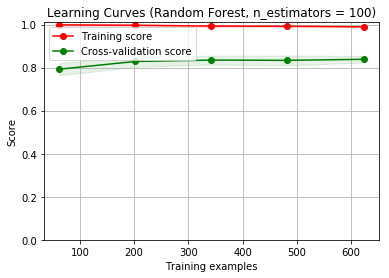

In [68]:
import matplotlib.pyplot as plt
title = "Learning Curves (Random Forest, n_estimators = 100)"
cv = cross_validation.ShuffleSplit(dataTrain.drop('Survived',1).shape[0], n_iter=10,test_size=0.3, random_state=0)
plot_learning_curve(RF, title, X_feature,y_t, (0.0, 1.01), cv=cv, n_jobs=4)
plt.show()